# Learning delays v01

I will start with the concept as shown in the below figure.
<br/><br/>


![](diagrams/learning_delays_v01_concept.png)

Method A: the aim is to pad the output spikes with a tensor of zeros then apply a delay. This will shift the spikes as shown in the figure, then the data will be surronded by zeros from both sides. However, this method will lead to misalignment between different anfs as some fibers will have the zero pad while others data at the same time point, which is not the case we expect. A possible solution is to clib the data as shown in Method B. I think, this will solve the problem, but will use a larger duration_steps. 

A way to implement this is shown below in the code. I think, this is not the only way and there is a paper that implemented the delays differently with a dedicated module: https://arxiv.org/abs/2205.02115. I have removed Dan's comments (sorry Dan) and some analysis to just focus on the delays.


Here is my thoughts on the topic if anyone is interested, if not, it is skippable :). I think, delays (given they have sufficient resolution) in their essence, and for the first layer, are a transformer from the time domain to the spatial domain. For a fixed duration_steps and after application of delays, all information is avilable in the first layer to do any computation on the information in this step. To learn far away concepts in the time domain, we either increase the max delays range in the first layer or apply a RNN.




In [63]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import torch
import torch.nn as nn
import torch.nn.functional as F

dtype = torch.float

# Check whether a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")     
else:
    device = torch.device("cpu")
    
my_computer_is_slow = True # set this to True if using Colab

Comment #1 If we set the no_phase_delays flag to 'True', some how the network learns and the loss is reduced. It is not as good as with phase_delays. I just find it weird. I think, it might be good to decouple and the study the effects of weights and delays separately. 

In [64]:
# Not using Brian so we just use these constants to make equations look nicer below
second = 1
ms = 1e-3
Hz = 1

"""Delay paramters"""
max_delay = 50*ms    # maximum allowed axonal delay during training
trainable_delays, no_phase_delays = True, False
num_ear = 2          # Who knows maybe there is an alien out there with more than 2 ears
lr_delay = 1e-3      # Not fine tuned much, but improves performance on no_delays case
""""""

# Stimulus and simulation parameters
dt = 1*ms            # large time step to make simulations run faster for tutorial
anf_per_ear = 100    # repeats of each ear with independent noise
envelope_power = 2   # higher values make sharper envelopes, easier
rate_max = 600*Hz   # maximum Poisson firing rate
f = 20*Hz            # stimulus frequency
duration = .1*second # stimulus duration
duration_steps = int(np.round(duration/dt))
input_size = 2*anf_per_ear

# Generate an input signal (spike array) from array of true IPDs
def input_signal(ipd):
    num_samples = len(ipd)
    T = np.arange(duration_steps)*dt # array of times
    phi = 2*np.pi*(f*T+np.random.rand()) # array of phases corresponding to those times with random offset
    # each point in the array will have a different phase based on which ear it is
    # and its delay
    theta = np.zeros((num_samples, duration_steps, 2*anf_per_ear))
    # for each ear, we have anf_per_ear different phase delays from to pi/2 so
    # that the differences between the two ears can cover the full range from -pi/2 to pi/2
    """Delay related update"""
    if trainable_delays or no_phase_delays:
        phase_delays = np.array([0]*anf_per_ear)
    else:
        phase_delays = np.linspace(0, np.pi/2, anf_per_ear)
    """"""
    # now we set up these theta to implement that. Some numpy vectorisation logic here which looks a little weird,
    # but implements the idea in the text above.
    theta[:, :, :anf_per_ear] = phi[np.newaxis, :, np.newaxis]+phase_delays[np.newaxis, np.newaxis, :]
    theta[:, :, anf_per_ear:] = phi[np.newaxis, :, np.newaxis]+phase_delays[np.newaxis, np.newaxis, :]+ipd[:, np.newaxis, np.newaxis]
    # now generate Poisson spikes at the given firing rate as in the previous notebook
    spikes = np.random.rand(num_samples, duration_steps, 2*anf_per_ear)<rate_max*dt*(0.5*(1+np.sin(theta)))**envelope_power
    return spikes

# Generate some true IPDs from U(-pi/2, pi/2) and corresponding spike arrays
def random_ipd_input_signal(num_samples, tensor=True):
    ipd = np.random.rand(num_samples)*np.pi-np.pi/2 # uniformly random in (-pi/2, pi/2)
    spikes = input_signal(ipd)
    if tensor:
        ipd = torch.tensor(ipd, device=device, dtype=dtype)        
        spikes = torch.tensor(spikes, device=device, dtype=dtype)
    return ipd, spikes

Comment #2 The main actors that made the differentiable delay possible are the 'F.affine_grid' and 'F.grid_sample' functions. They provided ways to shift the delays while keeping the input spike shape and content. These functions are used in spatial transformers. Togther, I think, they make a soft function by interpolating between the indices. Delays are index related and hence they are not differentiable, so these functions are one way of circumventing that.

In [65]:
"""Delay related functions"""

# Delays with constant or random initialisation
# Might think of other ways to initialize delays and their effect on performance
def init_delay_vector(constant=True, constant_value=0):
    if constant:
        delays = torch.nn.parameter.Parameter\
            (torch.FloatTensor([constant_value*ms]*anf_per_ear*num_ear), requires_grad=True)
    else:
        delays_numpy = np.random.randint(dt/ms, high=int(max_delay/ms), size=int(anf_per_ear*num_ear), dtype=int)*ms
        delays = torch.nn.parameter.Parameter(torch.FloatTensor(delays_numpy), requires_grad=True)
    return delays

delays_out = init_delay_vector(constant=False)

def apply_delays(spikes_in, delays):
    # Limiting applied delays to the range(0, max_delay)
    delays = torch.clamp(delays, min=0, max=max_delay - ms) / ms
    # Expand the dimenion as required by the functions
    spikes_in = spikes_in[:, None, :, :]
    spikes_size = spikes_in.size()
    zero_pad = torch.zeros((spikes_size[0], spikes_size[1], int(max_delay/ms), spikes_size[3]))
    # Applying the zero pad
    spikes_in = torch.cat((zero_pad, spikes_in), 2)
    spikes_in = torch.transpose(spikes_in, 0, 3)
    spikes_size = spikes_in.size()
    batch_size_in, height, width = spikes_size[0], spikes_size[2], spikes_size[3]
    # Applying a transformation with only translation
    affine_transformation = torch.zeros(batch_size_in, 2, 3)
    affine_transformation[:, 0, 0] = 1
    affine_transformation[:, 1, 1] = 1
    affine_transformation[:, 1, 2] = (2/height)*delays  # This is very important: delays have to be whole numbers or they will alter the input spikes values and distribution.
    grid = F.affine_grid(affine_transformation, (batch_size_in, 1, height, width), align_corners=False)
    # Grid sampling to acquire the shifted spikes
    spikes_out = F.grid_sample(spikes_in, grid, align_corners=False)
    spikes_out = torch.transpose(spikes_out, 0, 3)
    spikes_out = torch.squeeze(spikes_out)
    return spikes_out

In [66]:
# classes at 15 degree increments
num_classes = 180//15
print(f'Number of classes = {num_classes}')

def discretise(ipds):
    return ((ipds+np.pi/2)*num_classes/np.pi).long() # assumes input is tensor

def continuise(ipd_indices): # convert indices back to IPD midpoints
    return (ipd_indices+0.5)/num_classes*np.pi-np.pi/2

Number of classes = 12


In [67]:
# Weights and uniform weight initialisation
def init_weight_matrix():
    # Note that the requires_grad=True argument tells PyTorch that we'll be computing gradients with
    # respect to the values in this tensor and thereby learning those values. If you want PyTorch to
    # learn some gradients, make sure it has this on.
    W = nn.Parameter(torch.empty((input_size, num_classes), device=device, dtype=dtype, requires_grad=True))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(W)
    bound = 1 / np.sqrt(fan_in)
    nn.init.uniform_(W, -bound, bound)
    return W

In [68]:
# Parameters for training. These aren't optimal, but instead designed
# to give a reasonable result in a small amount of time for the tutorial!
if my_computer_is_slow:
    batch_size = 64
    n_training_batches = 64
else:
    batch_size = 128
    n_training_batches = 128
n_testing_batches = 32
num_samples = batch_size*n_training_batches

# Generator function iterates over the data in batches
# We randomly permute the order of the data to improve learning
def data_generator(ipds, spikes):
    perm = torch.randperm(spikes.shape[0])
    spikes = spikes[perm, :, :]
    ipds = ipds[perm]
    n, _, _ = spikes.shape
    n_batch = n//batch_size
    for i in range(n_batch):
        x_local = spikes[i*batch_size:(i+1)*batch_size, :, :]
        y_local = ipds[i*batch_size:(i+1)*batch_size]
        yield x_local, y_local

In [69]:
beta = 5

class SurrGradSpike(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        # Original SPyTorch/SuperSpike gradient
        # This seems to be a typo or error? But it works well
        #grad = grad_output/(100*torch.abs(input)+1.0)**2
        # Sigmoid
        grad = grad_output*beta*torch.sigmoid(beta*input)*(1-torch.sigmoid(beta*input))
        return grad

spike_fn  = SurrGradSpike.apply

In [70]:
num_hidden = 30

# Weights and uniform weight initialisation
def init_weight_matrices():
    # Input to hidden layer
    W1 = nn.Parameter(torch.empty((input_size, num_hidden), device=device, dtype=dtype, requires_grad=True))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(W)
    bound = 1 / np.sqrt(fan_in)
    nn.init.uniform_(W1, -bound, bound)
    # Hidden layer to output
    W2 = nn.Parameter(torch.empty((num_hidden, num_classes), device=device, dtype=dtype, requires_grad=True))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(W)
    bound = 1 / np.sqrt(fan_in)
    nn.init.uniform_(W2, -bound, bound)
    return W1, W2

# Run the simulation
def snn(input_spikes, W1, W2, delays, tau=20*ms):
    """Delay related update"""
    if trainable_delays:
        input_spikes = apply_delays(input_spikes, delays)
        duration_in = duration_steps + int(max_delay / ms)
    else:
        duration_in = duration_steps
    """"""
    # First layer: input to hidden
    v = torch.zeros((batch_size, num_hidden), device=device, dtype=dtype)
    s = torch.zeros((batch_size, num_hidden), device=device, dtype=dtype)
    s_rec = [s]
    h = torch.einsum("abc,cd->abd", (input_spikes, W1))
    alpha = np.exp(-dt/tau)
    """Delay related update"""
    for t in range(duration_in - 1):
        new_v = (alpha*v + h[:, t, :])*(1-s) # multiply by 0 after a spike
        s = spike_fn(v-1) # threshold of 1
        v = new_v
        s_rec.append(s)
    s_rec = torch.stack(s_rec, dim=1)
    # Second layer: hidden to output
    v = torch.zeros((batch_size, num_classes), device=device, dtype=dtype)
    s = torch.zeros((batch_size, num_classes), device=device, dtype=dtype)
    v_rec = [v]
    h = torch.einsum("abc,cd->abd", (s_rec, W2))
    alpha = np.exp(-dt/tau)
    """Delay related update"""
    for t in range(duration_in - 1):
        v = alpha*v + h[:, t, :]
        v_rec.append(v)
    v_rec = torch.stack(v_rec, dim=1)
    # Return recorded membrane potential of output
    return v_rec

Comment #3 The next issue, after the differntiable delays, is the application of the gradients. The gradients need to be within a reasonable range (a fraction of the maximum delay) and a multiple of the dt (minimum delay). For this reason I used SGD with 0 parameters so that the update is: delays_new = delays_old + lr_delay*gradients. I think a dedicated optimizer might be needed to provide a robust and safe way to apply the gradients to ensure that the updated delays are always whole numbers. 

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=2.32046
Epoch 2: loss=1.63760
Epoch 3: loss=1.41692
Epoch 4: loss=1.25174
Epoch 5: loss=1.03296
Epoch 6: loss=0.92214
Epoch 7: loss=0.81613
Epoch 8: loss=0.78015
Epoch 9: loss=0.71864
Epoch 10: loss=0.69677


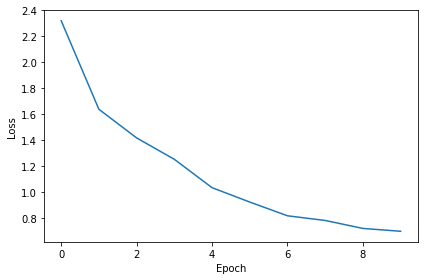

In [71]:
# Training parameters
nb_epochs = 10 # quick, it won't have converged
lr = 0.01 # learning rate

# Generate the training data
ipds, spikes = random_ipd_input_signal(num_samples)

# Initialise a weight matrix
W = init_weight_matrix()
# Initialise a weight matrices
W1, W2 = init_weight_matrices()

# Optimiser and loss function
optimizer = torch.optim.Adam([W1, W2], lr=lr)
log_softmax_fn = nn.LogSoftmax(dim=1)
loss_fn = nn.NLLLoss()
"""Delay related update"""
optimizer_delay = torch.optim.SGD([delays_out], lr=lr_delay, weight_decay=0, momentum=0)

print(f"Want loss for epoch 1 to be about {-np.log(1/num_classes):.2f}, multiply m by constant to get this")

loss_hist = []
for e in range(nb_epochs):
    local_loss = []
    for x_local, y_local in data_generator(discretise(ipds), spikes):
        # Run network
        """Delay related update"""
        # Apply the delays only to the input spikes
        output = snn(x_local, W1, W2, delays_out)
        """"""
        # Compute cross entropy loss
        m = torch.mean(output, 1)  # Mean across time dimension
        loss = loss_fn(log_softmax_fn(m), y_local)
        local_loss.append(loss.item())
        # Update gradients
        """Delay related update"""
        if trainable_delays:
            optimizer.zero_grad()
            optimizer_delay.zero_grad()
            loss.backward()
            #  This is a crucial part, controlling the applied gradients is important to ensure that the updated delays are whole numbers.
            delays_out.grad = torch.round(delays_out.grad)  # Might need optimizing like applying a clip function
            optimizer_delay.step()
            optimizer.step()
        else:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        """"""

    loss_hist.append(np.mean(local_loss))
    print("Epoch %i: loss=%.5f"%(e+1, np.mean(local_loss)))

# Plot the loss function over time
plt.plot(loss_hist)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()

Comment #4: This is a protoype of what I think might work and needs more work. Here is a list of things I think can be done regarding the work here:
1) Check the code works as intended
2) Code optimization to facilitate learning
3) Apply Method B: shift + clip
4) A dedicated optimizer or a robust and general way to update the gradients to ensure that the updated delays are whole numbers. The gradients are discrete and should be in multiples of dt. 
5) Maybe a dedicated delays optimizer?
6) Other methods?

Finally, comments, suggestions and questions would be welcome and helpful. I am not an expert in this area so this might be slow. If anyone is any expert, I don't mind handing over.